In [45]:
import sys
sys.path.append("../")
import numpy as np
from sanchez_ansatz import SanchezAnsatz
from qiskit import transpile
import matplotlib.pyplot as plt

Circuito original

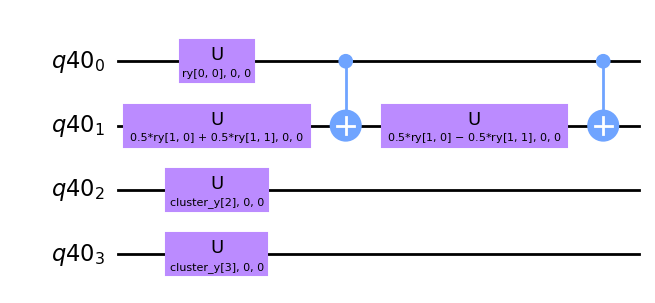

In [56]:
# Hyperparams
num_qubits = 4
eps = 0.3

# building target state
target_state = np.random.rand(2**num_qubits)
target_state = target_state / np.linalg.norm(target_state)

# creating circuit
circuit = SanchezAnsatz(target_state, eps)
init_params = circuit.init_params

t_circuit = transpile(circuit, basis_gates=["u", "cx"])
t_circuit.draw("mpl")

Utilizando funções

In [57]:
from qiskit_aer import Aer
from qiskit_algorithms.optimizers import SPSA

def run_experiment(ansatz, x0):
    sv_sim = Aer.get_backend("statevector_simulator")

    loss_history = []

    def callback(value):
        loss_history.append(value)

    def objective_fn(x):
        # extracting statevector data
        temp_ansatz = ansatz.assign_parameters(x)
        job = sv_sim.run(temp_ansatz)
        result = job.result()
        statevector = result.get_statevector()
        sv_data = statevector.data

        #computing loss
        fid_loss = 1 - np.abs(target_state @ sv_data) ** 2
        
        callback(fid_loss)
        
        return fid_loss

    optimizer = SPSA()
    result = optimizer.minimize(fun=objective_fn, x0=x0)
    return result, loss_history

In [58]:
result_original, history_original = run_experiment(t_circuit, init_params)

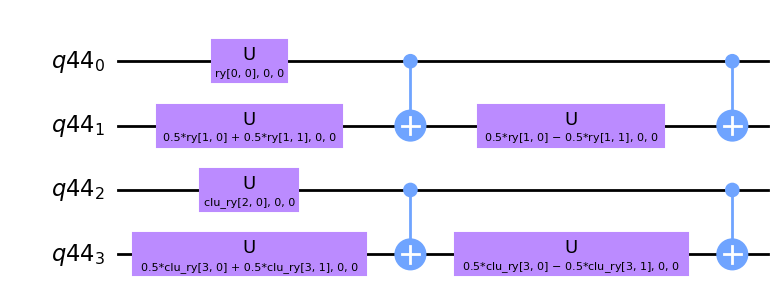

In [59]:
mod_circuit = SanchezAnsatz(target_state, eps, build_modified=True)
mod_init_params = mod_circuit.init_params

t_mod = transpile(mod_circuit, basis_gates=['cx', 'u'])
display(t_mod.draw("mpl"))

result_modified, history_modified = run_experiment(t_mod, mod_init_params)

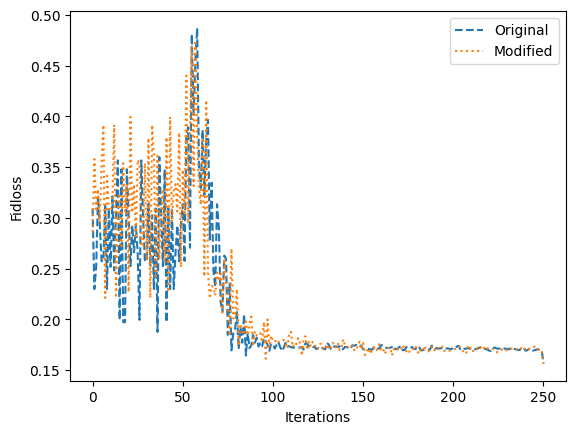

In [66]:
plt.plot(history_original, "--", label="Original")
plt.plot(history_modified, ":", label="Modified")
plt.ylabel("Fidloss")
plt.xlabel("Iterations")
plt.legend(loc="best")
plt.show()